We want to determine those clients whom we should incentivise in order to minimise churning.

In [818]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, auc, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from IPython import display
from IPython.display import display

%matplotlib inline
sns.set(rc={'figure.figsize': (15,8)}) # Size all seaborn plots from the get go

In [819]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [820]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [821]:
len(df)

7043

In [822]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [823]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [824]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
print(string_columns)

['customerid', 'gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'churn']


In [825]:
for column in string_columns:
    df[column] = df[column].str.lower().str.replace(" ", "_")

In [826]:
# Our dependent variable is categorical - switch to numerical
# Yes/No --> Boolean --> cast to int (yes --> True = 1, no --> False = 0)
df.churn = (df.churn == 'yes').astype(int)

In [827]:
# Split the data into training and test sets:

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Split the training data into training and validation sets

df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=42)

y_train = df_train.churn.values # We just want the values as a np array, not the panda series
y_val = df_val.churn.values

In [828]:
df_train_full.isnull().sum()
# There are no missing values that we have to deal with.

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [829]:
# What proportion of our training set churned?

prop = df_train_full.value_counts(['churn'], normalize=True)
print(prop)

# The 1 represents those who churned, so 26.55% churned
# We have a significant class imbalance

churn
0        0.734469
1        0.265531
dtype: float64


In [830]:
df.dtypes


customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

In [831]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']

numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [832]:
# Just to make sure wer haven't mis-categorised
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### Feature Importance Analysis

In [833]:
overall_churn_mean = df_train_full.churn.mean()
print(overall_churn_mean)

0.2655307064252751


In [834]:
# Let's look at the gender categorical attribute of the customers

female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
print(female_mean)

male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print(male_mean)

0.2708409173643975
0.26047800484932454


26.55% is our average churn rate across the train_full data subset - for females this is 27.08% and for males this is 26.05% - we can infer that gender isn't contributing to churn.

In [835]:
# Looking at the partner categorical attribute

partner_yes_mean = df_train_full[df_train_full.partner == 'yes'].churn.mean()
print(partner_yes_mean)

partner_no_mean = df_train_full[df_train_full.partner == 'no'].churn.mean()
print(partner_no_mean)

0.20073260073260074
0.32644628099173556


20% of those with a partner churn, whereas 32.64% of those without a partner churn - people who are single are more likely to churn. We can look at the risk of a single person churning.

In [836]:
# The risk of a negative outcome in a given group = the negative outcome in that group / the negative outcome overall - less than 1 = low risk, 1 = same risk, greater than 1 = high risk
risk_single_churning = partner_no_mean/overall_churn_mean

print(risk_single_churning)

1.2294106598311754


In [837]:
# Applying this across the board through a loop

for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['Diff'] = df_group['mean'] - overall_churn_mean
    df_group['Risk'] = df_group['mean']/overall_churn_mean
    display(df_group)


,mean,Diff,Risk
gender,,,
female,0.270841,0.005310,1.019998
male,0.260478,-0.005053,0.980971


,mean,Diff,Risk
seniorcitizen,,,
0,0.237098,-0.028433,0.892922
1,0.413907,0.148377,1.558793


,mean,Diff,Risk
partner,,,
no,0.326446,0.060916,1.229411
yes,0.200733,-0.064798,0.755968


,mean,Diff,Risk
dependents,,,
no,0.312326,0.046795,1.176233
yes,0.155674,-0.109856,0.586276


,mean,Diff,Risk
phoneservice,,,
no,0.253623,-0.011908,0.955156
yes,0.266824,0.001293,1.004871


,mean,Diff,Risk
multiplelines,,,
no,0.251397,-0.014134,0.946771
no_phone_service,0.253623,-0.011908,0.955156
yes,0.284105,0.018574,1.069952


,mean,Diff,Risk
internetservice,,,
dsl,0.191851,-0.073679,0.722521
fiber_optic,0.415558,0.150028,1.565010
no,0.076606,-0.188924,0.288502


,mean,Diff,Risk
onlinesecurity,,,
no,0.416014,0.150484,1.566727
no_internet_service,0.076606,-0.188924,0.288502
yes,0.145342,-0.120189,0.547363


,mean,Diff,Risk
onlinebackup,,,
no,0.398693,0.133162,1.501494
no_internet_service,0.076606,-0.188924,0.288502
yes,0.216531,-0.048999,0.815467


,mean,Diff,Risk
deviceprotection,,,
no,0.387706,0.122175,1.460117
no_internet_service,0.076606,-0.188924,0.288502
yes,0.226825,-0.038705,0.854234


,mean,Diff,Risk
techsupport,,,
no,0.413472,0.147941,1.557153
no_internet_service,0.076606,-0.188924,0.288502
yes,0.152855,-0.112676,0.575657


,mean,Diff,Risk
streamingtv,,,
no,0.335418,0.069887,1.263197
no_internet_service,0.076606,-0.188924,0.288502
yes,0.298945,0.033415,1.125841


,mean,Diff,Risk
streamingmovies,,,
no,0.333333,0.067803,1.255348
no_internet_service,0.076606,-0.188924,0.288502
yes,0.301320,0.035789,1.134784


,mean,Diff,Risk
contract,,,
month-to-month,0.426533,0.161002,1.606340
one_year,0.117987,-0.147544,0.444343
two_year,0.028379,-0.237151,0.106878


,mean,Diff,Risk
paperlessbilling,,,
no,0.16414,-0.101390,0.618159
yes,0.33594,0.070409,1.265164


,mean,Diff,Risk
paymentmethod,,,
bank_transfer_(automatic),0.174475,-0.091056,0.657080
credit_card_(automatic),0.152404,-0.113126,0.573961
electronic_check,0.449921,0.184390,1.694420
mailed_check,0.190328,-0.075203,0.716782


We can use mutual information to further drill into the relationships between the categorical variables and the target variable which can then allow us to decide which variables to keep and which ones to ??disregard

In [838]:
def calculate_mutual_information(series):
    """
    A function to return the mutual information between a series/column within our dataframe
    and the churn target variable
    :param series: A series/column from our dataframe
    :return: A mutual information score between the series and the churn target variable
    """
    return mutual_info_score(series, df_train_full.churn)

In [839]:
df_mi = df_train_full[categorical].apply(calculate_mutual_information)
# Sort the values of the above from most informative to least
df_mi = df_mi.sort_values(ascending=False).to_frame(name='mutual_information')
df_mi

,mutual_information
contract,0.096652
onlinesecurity,0.063393
techsupport,0.060935
internetservice,0.053313
onlinebackup,0.045424
paymentmethod,0.042861
deviceprotection,0.042007
streamingtv,0.030844
streamingmovies,0.030705
paperlessbilling,0.019077


For the numerical (or non-categorical) variables we can use the correlation co-efficient (Pearson's)
0 --> No correlation
1 --> Fully positively correlated
-1 --> Fully negatively correlated

In [840]:
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.344925
monthlycharges    0.188574
totalcharges     -0.193370
dtype: float64

### Feature Engineering

In [841]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
print(train_dict[0])

{'gender': 'female', 'seniorcitizen': 0, 'partner': 'no', 'dependents': 'no', 'phoneservice': 'yes', 'multiplelines': 'no', 'internetservice': 'fiber_optic', 'onlinesecurity': 'no', 'onlinebackup': 'no', 'deviceprotection': 'no', 'techsupport': 'no', 'streamingtv': 'no', 'streamingmovies': 'no', 'contract': 'month-to-month', 'paperlessbilling': 'yes', 'paymentmethod': 'electronic_check', 'tenure': 18, 'monthlycharges': 71.1, 'totalcharges': 1247.75}


In [842]:
# Use dict vectoriser from scikit-learn for one-hot encoding of the categorical variables

dict_vectoriser = DictVectorizer(sparse=False) # We want a numpy array not a sparse matrix
dict_vectoriser.fit(train_dict)

X_train = dict_vectoriser.transform(train_dict)

In [843]:
dict_vectoriser.get_feature_names()

/Users/darrenking/miniforge3/envs/env_ml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male',
 'internetservice=dsl',
 'internetservice=fiber_optic',
 'internetservice=no',
 'monthlycharges',
 'multiplelines=no',
 'multiplelines=no_phone_service',
 'multiplelines=yes',
 'onlinebackup=no',
 'onlinebackup=no_internet_service',
 'onlinebackup=yes',
 'onlinesecurity=no',
 'onlinesecurity=no_internet_service',
 'onlinesecurity=yes',
 'paperlessbilling=no',
 'paperlessbilling=yes',
 'partner=no',
 'partner=yes',
 'paymentmethod=bank_transfer_(automatic)',
 'paymentmethod=credit_card_(automatic)',
 'paymentmethod=electronic_check',
 'paymentmethod=mailed_check',
 'phoneservice=no',
 'phoneservice=yes',
 'seniorcitizen',
 'streamingmovies=no',
 'streamingmovies=no_internet_service',
 'streamingmovies=yes',
 'streamingtv=no',
 'streamingtv=no_internet_servic

### Model - Logistic Regression

In [844]:
# display.Image("./logistic_regression.png")

y = 1 means the customer churned, y = 0 means the customer stayed

In [845]:
# Define and fit our model on the training data

model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [846]:
# Test it against the validation dataset

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dict_vectoriser.transform(val_dict)

y_pred = model.predict_proba(X_val)
print(y_pred)

[[0.84642912 0.15357088]
 [0.72567614 0.27432386]
 [0.56220199 0.43779801]
 ...
 [0.33391452 0.66608548]
 [0.99711901 0.00288099]
 [0.70289228 0.29710772]]


The first column is the probability of that customer not churning
The second columns is the probability of that customer churning
(We really only need the second column).

In [847]:
y_pred = y_pred[:,1] # We need all the rows and just the second column which has index of 1

In [848]:
print(y_pred)

[0.15357088 0.27432386 0.43779801 ... 0.66608548 0.00288099 0.29710772]


In [849]:
# Create an array of booleans indicating whether a consumer is likely to churn
# which we can then compare to the y_val to assess the accuracy of our model.

churn = y_pred >= 0.5 # True = customer churns, False they won't
print(churn)

[False False False ...  True False False]


In [850]:
print(y_val) # 1 = customer churns, 0 they don't

[0 0 1 ... 1 0 0]


In [851]:
(y_val == churn).mean()

0.7973118279569893

The model has an accuracy of approximately 80% - not great; we'll explore further metrics on this below.

In [852]:
# For the logistic regression bias and model coefficients:

bias = model.intercept_[0]
print(bias)

weights = model.coef_[0]
print(weights)

-0.15395776026812832
[ 7.15473854e-01 -8.56790369e-02 -7.83752577e-01 -5.28398394e-02
 -1.01117921e-01 -1.83498150e-03 -1.30846476e-01 -2.12763024e-02
  4.04447017e-02 -1.94402462e-01 -3.35644436e-01  3.12533152e-01
 -1.30846476e-01  3.43428808e-03 -2.55406639e-01  1.00409590e-01
  1.03928846e-03  3.71017421e-02 -1.30846476e-01 -6.02130260e-02
  1.68951044e-01 -1.30846476e-01 -1.92062328e-01 -2.54906346e-01
  1.00948586e-01 -6.11247534e-02 -9.28330069e-02 -9.44536317e-02
 -1.81054032e-01  1.98708068e-01 -7.71581644e-02  1.00409590e-01
 -2.54367350e-01  9.31898126e-02 -1.69083879e-01 -1.30846476e-01
  1.45972595e-01 -6.10965797e-02 -1.30846476e-01  3.79852958e-02
  1.67158171e-01 -1.30846476e-01 -1.90269455e-01 -5.42702164e-02
  2.33428419e-04]


Note that the bias is negative, i.e. on average, churning has a negative bias. Logistic regression utilises a sigmoid curve with a central point of zero so a negative bias equates to a less than 0.5 probability (on a 0-1 probability scale). As such the negative bias shows, on average, without consideration of the other parameters that a customer is statistically less likely to churn than not churn - we know this from the statistical analysis above where the average churn rate is 26.55%

In [853]:
# We can look at the weights for each parameter:

parameter_weights = dict(zip(dict_vectoriser.get_feature_names_out(), model.coef_[0]))
print(parameter_weights)

{'contract=month-to-month': 0.7154738539999073, 'contract=one_year': -0.08567903694751232, 'contract=two_year': -0.7837525773205091, 'dependents=no': -0.052839839424461764, 'dependents=yes': -0.10111792084364128, 'deviceprotection=no': -0.0018349814991204271, 'deviceprotection=no_internet_service': -0.13084647631973223, 'deviceprotection=yes': -0.021276302449281238, 'gender=female': 0.040444701747489625, 'gender=male': -0.19440246201562786, 'internetservice=dsl': -0.335644435712886, 'internetservice=fiber_optic': 0.3125331517645093, 'internetservice=no': -0.13084647631973223, 'monthlycharges': 0.0034342880755537796, 'multiplelines=no': -0.25540663888266635, 'multiplelines=no_phone_service': 0.1004095901533147, 'multiplelines=yes': 0.0010392884612055952, 'onlinebackup=no': 0.03710174207519277, 'onlinebackup=no_internet_service': -0.13084647631973223, 'onlinebackup=yes': -0.06021302602358808, 'onlinesecurity=no': 0.16895104448479062, 'onlinesecurity=no_internet_service': -0.1308464763197

In [854]:
# We can look at a single customer...

customer = df[df.customerid == '8879-zkjof']
customer = customer.drop(['churn'], axis=1)
customer = customer.to_dict('records')[0]

X_test = dict_vectoriser.transform([customer])
model.predict_proba(X_test)

array([[0.92486228, 0.07513772]])

Again, the first figure is the probability of staying with the company and the second is the probability of churning for this particular customer calculated against our model.

## Evaluation Metrics For Classification

### Accuracy

In [855]:
# The accuracy on the validation set as we saw above - 80%

y_pred = model.predict_proba(X_val)[:,1]
churn = y_pred >= 0.5 # The accuracy is based on a 50% threshold
(churn == y_val).mean()

0.7973118279569893

In [856]:
# Looking at an array of thresholds

thresholds = np.linspace(0,1,11)
accuracy_scores = []

for threshold in thresholds:
    churn = y_pred >= threshold
    acc = accuracy_score(y_val, churn)
    accuracy_scores.append(acc)
    print("Accuracy: " , acc.round(4), " for a threshold of: ", threshold.round(1))

Accuracy:  0.2597  for a threshold of:  0.0
Accuracy:  0.6113  for a threshold of:  0.1
Accuracy:  0.6968  for a threshold of:  0.2
Accuracy:  0.7522  for a threshold of:  0.3
Accuracy:  0.7758  for a threshold of:  0.4
Accuracy:  0.7973  for a threshold of:  0.5
Accuracy:  0.7952  for a threshold of:  0.6
Accuracy:  0.7688  for a threshold of:  0.7
Accuracy:  0.7446  for a threshold of:  0.8
Accuracy:  0.7403  for a threshold of:  0.9
Accuracy:  0.7403  for a threshold of:  1.0


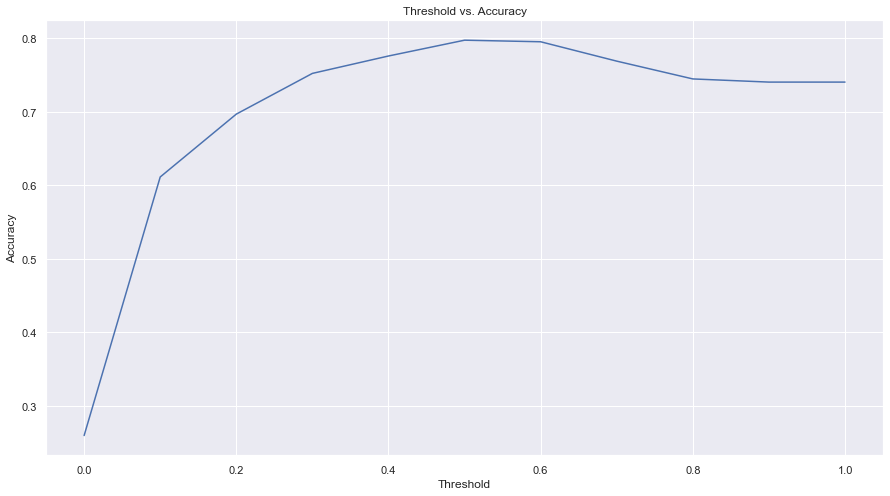

In [857]:
fig, ax = plt.subplots()
ax.set_title("Threshold vs. Accuracy")
ax.set_xlabel("Threshold")
ax.set_ylabel("Accuracy")
ax.plot(thresholds, accuracy_scores)

In [858]:
# How does our model compare against a dummy baseline which always predicts no churn

baseline = np.repeat(False, len(y_val))

accuracy_score(baseline, y_val)

0.7403225806451613

Our model is only 6% better than a dummy model that always predicts no churn - really not great. At least not great from an accuracy POV. But we do have to appreciate that our data set is imbalanced and that skew will obviosuly affect accuracy.

### Confusion Matrix

In [859]:
# Create a confusion matrix against our validation set

threshold = 0.5 # From our accuracy graph above this is the best threshold for accuracy
model_predicts_churn = (y_pred >= threshold)
model_no_predicts_churn = (y_pred < threshold)

actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

true_positive = (model_predicts_churn & actual_churn).sum()
false_positive = (model_predicts_churn & actual_no_churn).sum()

false_negative = (model_no_predicts_churn & actual_churn).sum()
true_negative = (model_no_predicts_churn & actual_no_churn).sum()

In [860]:
confusionmatrix = np.array([[true_negative, false_positive], [false_negative, true_positive]])
print(confusionmatrix)

[[1225  152]
 [ 225  258]]


In [861]:
# Represented as a proportional table
confusionmatrix/confusionmatrix.sum()

array([[0.65860215, 0.08172043],
       [0.12096774, 0.13870968]])

Predicts negative values correctly 65% of the time
Predicts positive values correctly 14% of the time

### Precision & Recall

We can use the confusion matrix; precision and recall are useful in the case of class imbalance in our model.

The Precision of our model is the percentage of positive predictions that are correct.

The Recall of our model is the percentage of positive predictions out of all positive samples/examples.

(Neither precision or recall take into account true negatives; it's all about the positive sample set.

In [862]:
precision = true_positive/(true_positive + false_positive)
print(precision)

0.6292682926829268


In [863]:
recall = true_positive/(true_positive + false_negative)
print(recall)

0.5341614906832298


Precision and recall are limited in that they describe the performance of a model at a given threshold. We need a metric that looks at our model for all possible thresholds.

### ROC Curve & AUC Score

ROC = Receiver Operating Characteristics - how well can a model seperate 2 classes?

ROC requires both FPR and TPR

In [864]:
# A small fpr indicates a good model
fpr = false_positive/(false_positive + true_negative)
print(fpr)

0.11038489469862019


In [865]:
# TPR is recall
tpr = true_positive/(true_positive + false_negative)
print(tpr)

0.5341614906832298


In [866]:
# Again we've only calculated these values for a particular threshold. So we need to calculate them against a few different thresholds.

scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    tp = ((y_pred >= t)&(y_val == 1)).sum()
    fp = ((y_pred >= t)&(y_val == 0)).sum()
    fn = ((y_pred < t)&(y_val == 1)).sum()
    tn = ((y_pred < t)&(y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

# Convert to pandas dataframe for ease of use

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores.head(10)

,threshold,tp,fp,fn,tn
0,0.00,483,1377,0,0
1,0.01,481,1193,2,184
2,0.02,479,1065,4,312
3,0.03,473,983,10,394
4,0.04,469,924,14,453
5,0.05,468,862,15,515
6,0.06,466,815,17,562
7,0.07,462,787,21,590
8,0.08,458,754,25,623
9,0.09,455,713,28,664


In [867]:
df_scores['tpr'] = df_scores.tp/(df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp/(df_scores.fp + df_scores.tn)

df_scores.head()

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,483,1377,0,0,1.000000,1.000000
1,0.01,481,1193,2,184,0.995859,0.866376
2,0.02,479,1065,4,312,0.991718,0.773420
3,0.03,473,983,10,394,0.979296,0.713871
4,0.04,469,924,14,453,0.971014,0.671024


In [868]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,483,1377,0,0,1.000000,1.000000
10,0.1,451,691,32,686,0.933747,0.501816
20,0.2,411,492,72,885,0.850932,0.357298
30,0.3,362,340,121,1037,0.749482,0.246914
40,0.4,318,252,165,1125,0.658385,0.183007
50,0.5,258,152,225,1225,0.534161,0.110385
60,0.6,191,89,292,1288,0.395445,0.064633
70,0.7,82,29,401,1348,0.169772,0.021060
80,0.8,8,0,475,1377,0.016563,0.000000
90,0.9,0,0,483,1377,0.000000,0.000000


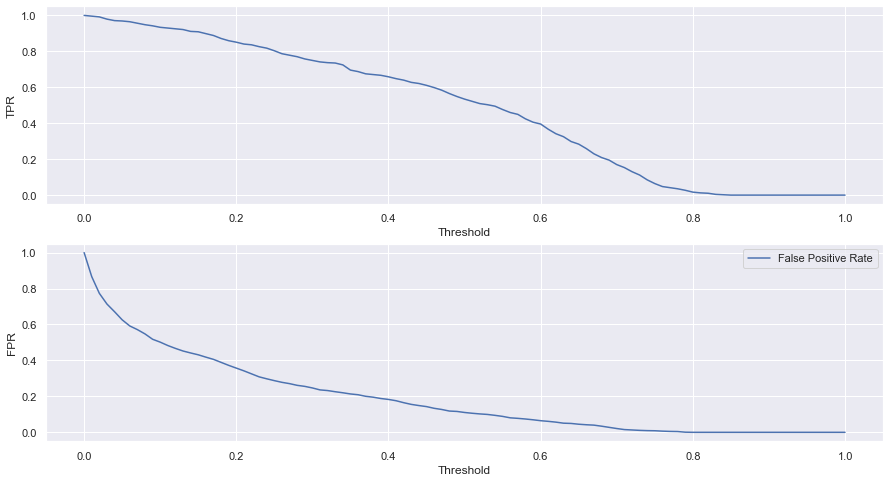

In [869]:
fig, ax = plt.subplots(2,1)
ax1 = ax[0]
ax2 = ax[1]
ax1.plot(df_scores.threshold, df_scores.tpr, label = "True Positive Rate")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("TPR")
ax2.plot(df_scores.threshold, df_scores.fpr, label = "False Positive Rate")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("FPR")
plt.legend()

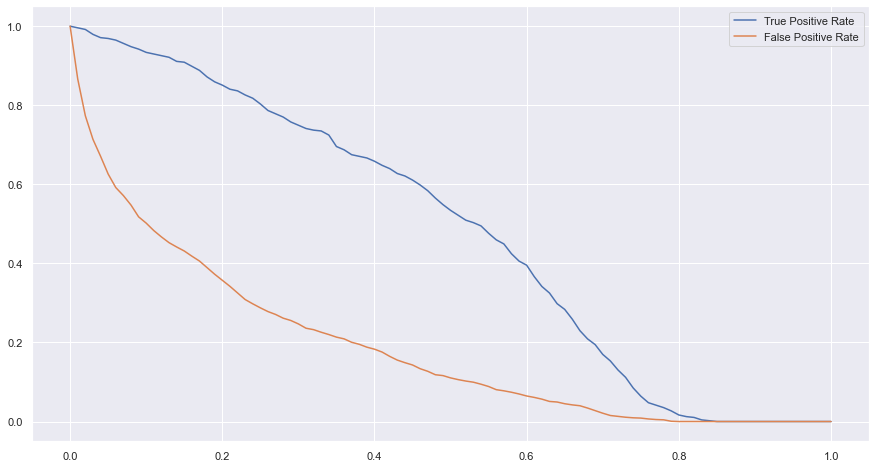

In [870]:
plt.plot(df_scores.threshold, df_scores.tpr, label = "True Positive Rate")
plt.plot(df_scores.threshold, df_scores.fpr, label = "False Positive Rate")
plt.legend()

For the ideal model FPR should drop quickly = model makes few mistakes predicting false positives

For the ideal model TPR should go down slowly = model predicts true positives well.

We can better understand this by creating a baseline random model; instead of using the predictions of our model, quickly generate random data to create a random model.
We can then compare that against a perfect model.

In [871]:
np.random.seed(42)

y_rand = np.random.uniform(0,1, len(y_val)) # These are the predictions of our random model

In [872]:
def tpr_fpr_dataframe (y_val, y_pred):
    """
    A function that takes in actual and predicted values from a model and
    returns a dataframe comprised of the true positive, false positive, tpr and fpr
    :param y_val: The actual values of our validation set
    :param y_pred: The predicted values of our model to compare against the validation set
    :return: A dataframe as described above.
    """

    scores = []

    thresholds = np.linspace(0,1,101)

    for t in thresholds:
        tp = ((y_pred >= t)&(y_val == 1)).sum()
        fp = ((y_pred >= t)&(y_val == 0)).sum()
        fn = ((y_pred < t)&(y_val == 1)).sum()
        tn = ((y_pred < t)&(y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))

    # Convert to pandas dataframe for ease of use

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp/(df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp/(df_scores.fp + df_scores.tn)

    return df_scores

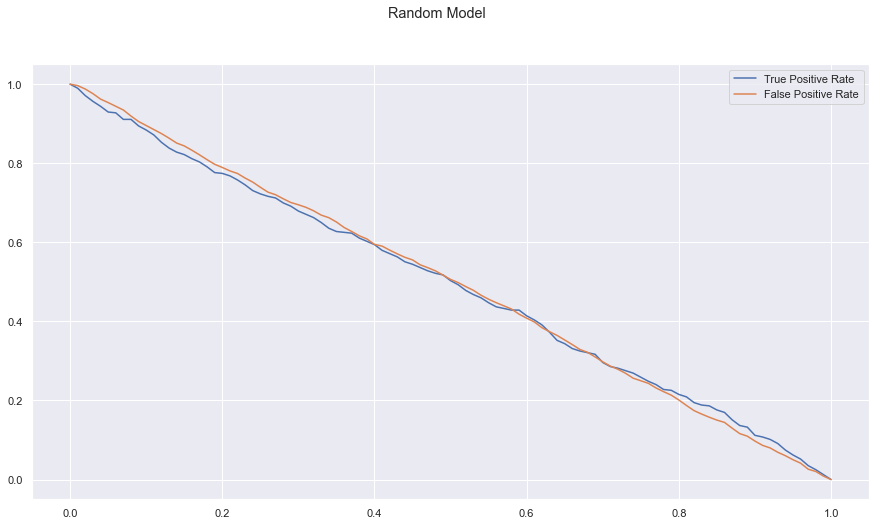

In [873]:
# Using the above function against our random model....

df_random = tpr_fpr_dataframe(y_val, y_rand)

# And plotting this as we did above
plt.plot(df_random.threshold, df_random.tpr, label = "True Positive Rate")
plt.plot(df_random.threshold, df_random.fpr, label = "False Positive Rate")
plt.suptitle("Random Model")
plt.legend()


In a random model both the TPR and the FPR will decrease from 100 to 0 at the same rate.

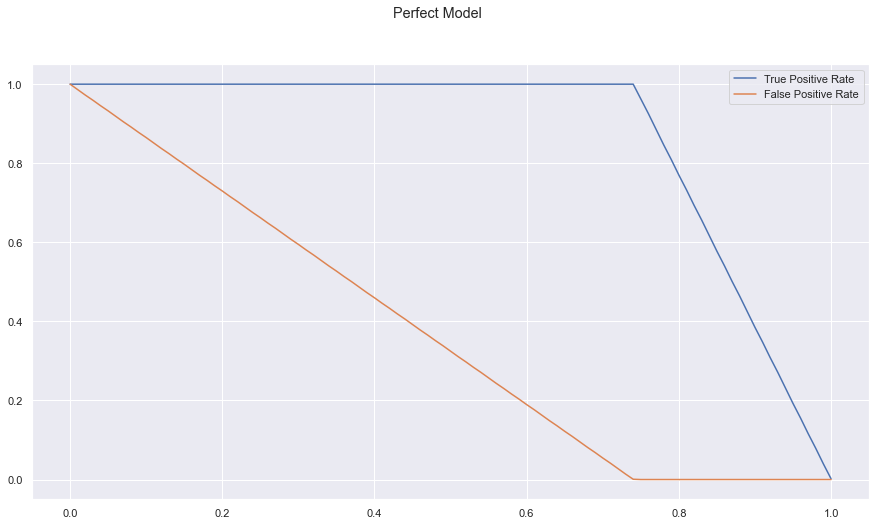

In [874]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_perfect = np.repeat([0,1], [num_neg, num_pos]) # Repeats 0 num_neg times, then 1 num_pos times
y_perfect_pred = np.linspace(0,1,(num_pos + num_neg))

# Using our previously defined function against our perfect model...
df_perfect = tpr_fpr_dataframe(y_perfect, y_perfect_pred)

# And plotting this as per above, again:

plt.plot(df_perfect.threshold, df_perfect.tpr, label = "True Positive Rate")
plt.plot(df_perfect.threshold, df_perfect.fpr, label = "False Positive Rate")
plt.suptitle("Perfect Model")
plt.legend()


In the case of a ROC curve we plot FPR against TPR and include the ideal and random models for comparative purposes - a model should always be between the random and the perfect model; the closer to the perfect model the better.

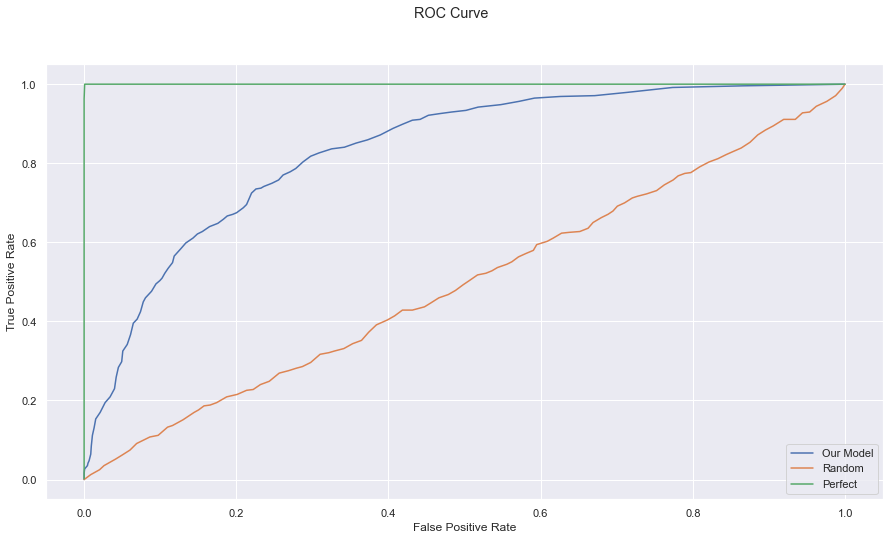

In [875]:
plt.plot(df_scores.fpr, df_scores.tpr, label = "Our Model")
plt.plot(df_random.fpr, df_random.tpr, label = "Random")
plt.plot(df_perfect.fpr, df_perfect.tpr, label = "Perfect")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.suptitle("ROC Curve")
plt.legend()

We could represent this in a different manner...

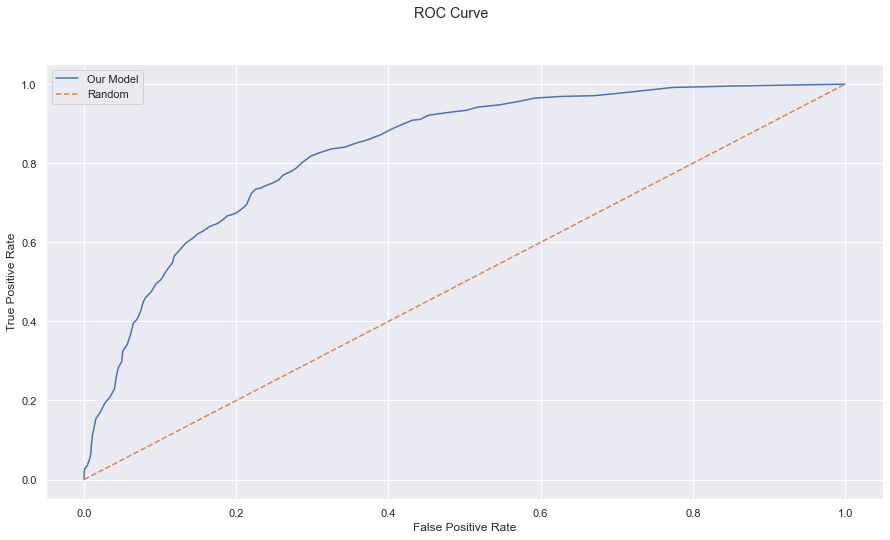

In [876]:
plt.plot(df_scores.fpr, df_scores.tpr, label = "Our Model")
plt.plot([0,1], [0,1], linestyle = 'dashed', label = "Random")
# plt.plot(df_perfect.fpr, df_perfect.tpr, label = "Perfect")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.suptitle("ROC Curve")
plt.legend()

In [877]:
# The auc --> what is the probability that a randomly selected positive example will have a score higher than a
# randomly selected negative example

area_under_curve = auc(df_scores.fpr, df_scores.tpr)
print(area_under_curve)

0.8325823082856331


In [879]:
# Alternatively, without having to precalculate the fpr and tpr:

area_under_curve = roc_auc_score(y_val, y_pred)
print(area_under_curve)

0.8323537681309776
